# Encoding Comparison for UI Logs

We are investigating the methods used in the paper title "Enabling Routine Discovery from High-Noise UI Logs: A Time Series Data Mining Approach".
We implemented and tested three methods:
 - Continuous Hot Encoding, which just assigns every unique instance occured an ID or takes the ID previously assigned
 - Co-Occurance Encoding, based on the second Eigenvector, called Fielder-Vector, describing the co-occurance pattern
 - UI Hierarchy Based Encoding, starting of the Abb/Rehse Reference Model to align attributes relevant for encoding 


In [1]:
import pandas as pd
import stumpy
from stumpy import config
import numpy as np
import time
import util.util
import matplotlib.pyplot as plt

In [ ]:
# SMART RPA log

# Optional if an existing log should be used
file_path = '../logs/Banking/'  # Replace with your file path

file_name = "RunningExampleSmartRPA_Anonymized.csv"
ContextColumns = ["category","application","event_src_path","title","workbook","concept:name"]

file_name = "RunningExampleSmartRPA_Anonymized - Copy.csv"
ContextColumns = ["category","application","event_src_path","top_level_url","title","workbook","concept:name"]

uiLog = pd.read_csv(file_path + file_name,sep=";")

# groundTruth = [298, 1234,2330,2662,2705,2764,2932] # Ground truth for the Running Example

windowSize = 25
numberOfMotifs = 10

# Tockler Log
file_path = '../logs/AWT/'  # Replace with your file path
file_name = "AWT_data_Iris_March_2023_labelled_step5.csv"
ContextColumns = ["App","Title"]
uiLog = pd.read_csv(file_path + file_name,sep=";")

### Plot all three encoding variants and how they differ

In [3]:
hierarchyEncodedUiLog = []
hierarchyEncodedUiLogTime = time.time()
hierarchyEncodedUiLog = util.util.encoding_UiLog(uiLog,orderedColumnsList=ContextColumns,encoding=1)
hierarchyEncodedUiLogTime = time.time() - hierarchyEncodedUiLogTime
print(f"Encoding time for hierarchy encoding: {hierarchyEncodedUiLogTime}")
hierarchyEncodedUiLog = hierarchyEncodedUiLog.reset_index(drop=True)

cooccurancyEncodedUiLog = []
cooccurancyEncodedUiLogTime = time.time()
cooccurancyEncodedUiLog = util.util.encoding_UiLog(uiLog,orderedColumnsList=ContextColumns,encoding=2)
cooccurancyEncodedUiLogTime = time.time() - cooccurancyEncodedUiLogTime
print(f"Encoding time for co-occurancy encoding: {cooccurancyEncodedUiLogTime}")
cooccurancyEncodedUiLog = cooccurancyEncodedUiLog.reset_index(drop=True)

HotEncodedUiLog = []
HotEncodedUiLogTime = time.time()
HotEncodedUiLog = util.util.encoding_UiLog(uiLog,orderedColumnsList=ContextColumns,encoding=3)
HotEncodedUiLogTime = time.time() - HotEncodedUiLogTime
print(f"Encoding time for hot encoding: {HotEncodedUiLogTime}")
HotEncodedUiLog = HotEncodedUiLog.reset_index(drop=True)

Encoding time for hierarchy encoding: 0.03281140327453613
Encoding time for co-occurancy encoding: 13.585463523864746
Encoding time for hot encoding: 0.08711004257202148


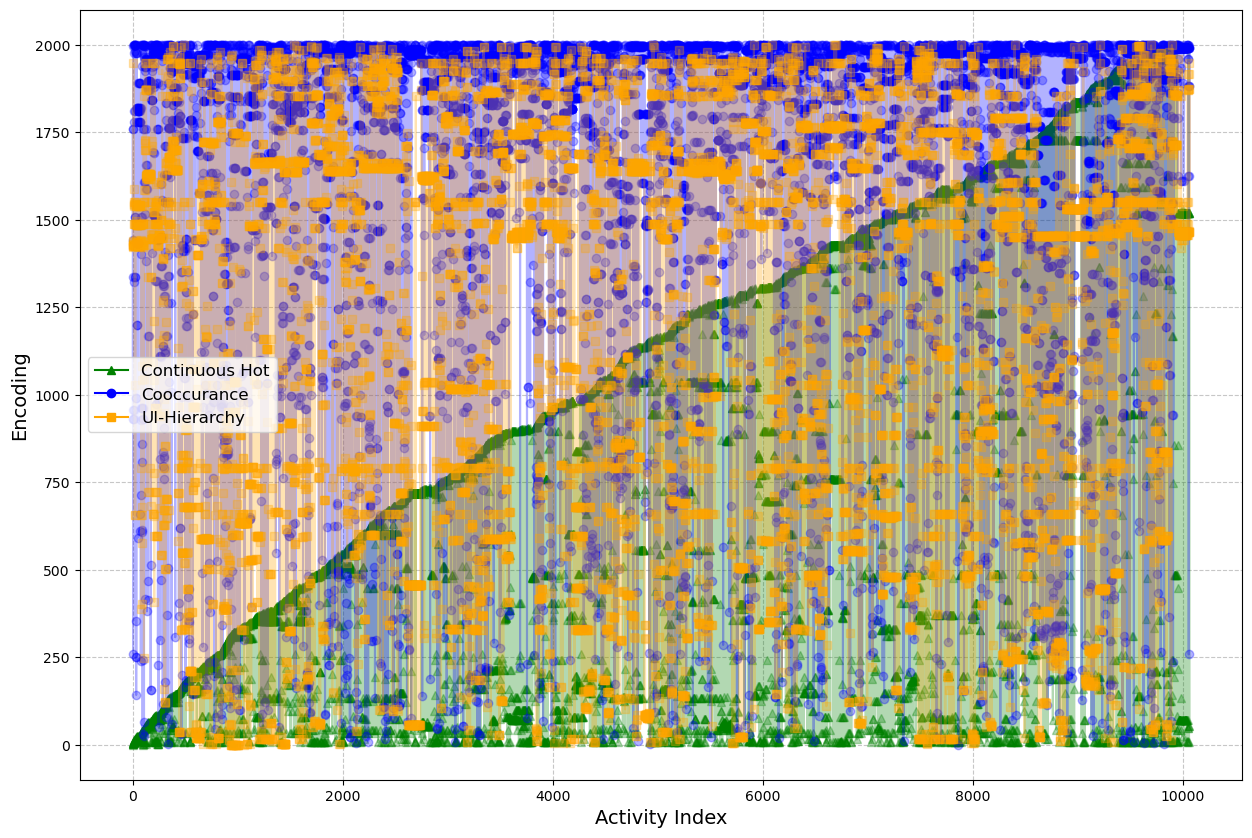

,Log Name,windowSize,Recall,Precision,F1_score,Top Motifs,DiscoveryTime,Encoding Time
0,Hot Encoded,25,?,?,?,"[1690, 2482, 2657, 2699, 3987, 5773, 8969, 8995, 9960, 10014]",1.07206,0.087110
1,Co-occurrence Encoded,25,?,?,?,"[2657, 2699, 2835, 2965, 3165, 6958, 8229, 8970, 8996, 10016]",0.98706,13.585464
2,Hierarchy Encoded,25,?,?,?,"[1304, 2630, 2657, 2699, 6645, 6962, 7744, 8969, 8995, 10016]",0.97139,0.032811


In [11]:
# Define the dataframes
logs = {
    "Hot Encoded": HotEncodedUiLog,
    "Co-occurrence Encoded": cooccurancyEncodedUiLog,
    "Hierarchy Encoded": hierarchyEncodedUiLog
}

# ---- Creating the plot ----
# Function to plot tuple:id from three dataframes
def plot_tuple_ids(cont_hot_df: pd.DataFrame, cooc_df: pd.DataFrame, 
                   hierarch_df: pd.DataFrame, window_size: int, groundTruth: list=None):
    plt.figure(figsize=(15, 10))

    # Plot tuple:id for each dataframe
    plt.plot(cont_hot_df['tuple:id'], label='Continuous Hot', marker='^', markersize=6, c="green")
    plt.plot(cooc_df['tuple:id'], label='Cooccurance', marker='o', markersize=6, c="blue")
    plt.plot(hierarch_df['tuple:id'], label='UI-Hierarchy', marker='s', markersize=6, c="orange")

    # Highlight sections around groundTruth indices
    if groundTruth is not None:
        for index in groundTruth:
            start = max(0, index - window_size)
            end = min(max(len(cont_hot_df),len(cooc_df),len(hierarch_df)), index + window_size)
            plt.axvspan(start, end, color='grey', alpha=0.7, label='Ground Truth Window' if index == groundTruth[0] else "")

    # Adding titles and labels
    plt.xlabel('Activity Index', fontsize=14)
    plt.ylabel('Encoding', fontsize=14)

    # Adding legend
    plt.legend(fontsize=12)

    # Adding grid for better readability
    plt.grid(linestyle='--', alpha=0.7)

    # Reduce the opacity of the lines
    for line in plt.gca().get_lines():
        line.set_alpha(0.3)

    # Show the plot
    plt.show()
    

# Call the function
if 'groundTruth' in locals():
    plot_tuple_ids(cont_hot_df=HotEncodedUiLog, cooc_df=cooccurancyEncodedUiLog, 
               hierarch_df=hierarchyEncodedUiLog, groundTruth=groundTruth,
               window_size=windowSize)
else: 
    plot_tuple_ids(cont_hot_df=HotEncodedUiLog, cooc_df=cooccurancyEncodedUiLog, 
               hierarch_df=hierarchyEncodedUiLog, window_size=windowSize)

# ---- Calculate statistical measures ----
# Initialize a results list
results = []

# Perform calculations for each log
for log_name, log_df in logs.items():
    # Ensure the indices exist in the dataframe
    range_block = list(range(0, len(log_df)))
    missing_indices = [idx for idx in range_block if idx not in log_df.index]
    if missing_indices:
        print(f"Skipping {log_name}: Missing indices {missing_indices}")
        continue

    else:
        # Extract the relevant rows
        subset = log_df.loc[range_block, 'tuple:id']
        
        # Calculate the median value for the range
        median_value_range = subset.median()
        
        # Calculate the consecutive differences and their median for the range
        differences_range = subset.diff().dropna()
        median_difference_range = differences_range.median()


    # Generate the matrix profil
    discoveryTime = time.time()
    tm_matrix, event_series = util.util.discover_motifs(log_df, windowSize, normalize=False)
    config.STUMPY_EXCL_ZONE_DENOM = 1  # The exclusion zone is i ± window_size
    top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=numberOfMotifs)
    discoveryTime = time.time() - discoveryTime 

    if 'groundTruth' in locals():
        insert_spots, motif_spots, overlapDF = util.util.compare_sets(set(groundTruth), set(top_motifs[1][0]), (windowSize/2))
        ground_truth_sum = len(groundTruth) # Total number of motifs in the ground truth
        true_positives = len(insert_spots) # Correctly identified motifs
        false_positives = numberOfMotifs - true_positives  # Incorrectly identified motifs
        false_negatives = ground_truth_sum - true_positives  # Relevant motifs not identified
        # Precision
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        # Recall
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        # F1-Score
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Append results to the list
        results.append({
            "Log Name": log_name,
            "windowSize": windowSize,
            "Recall": recall,
            "Precision": precision,
            "F1_score": f1_score,
            "Ground Truth": groundTruth,
            "Top Motifs": sorted(top_motifs[1][0]),
            "DiscoveryTime": discoveryTime,
        })
    else:
        # Append results to the list
        results.append({
            "Log Name": log_name,
            "windowSize": windowSize,
            "Recall": "?",
            "Precision": "?",
            "F1_score": "?",
            "Top Motifs": sorted(top_motifs[1][0]),
            "DiscoveryTime": discoveryTime,
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
# Add encoding time to each log's results
for result in results:
    log_name = result["Log Name"]
    if log_name == "Hierarchy Encoded":
        result["Encoding Time"] = hierarchyEncodedUiLogTime
    elif log_name == "Hot Encoded":
        result["Encoding Time"] = HotEncodedUiLogTime
    elif log_name == "Co-occurrence Encoded":
        result["Encoding Time"] = cooccurancyEncodedUiLogTime

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
pd.set_option("display.max_colwidth", None) 
results_df

In [43]:
from scipy.spatial.distance import euclidean

# Function to calculate pairwise Euclidean distances for groundTruth subsequences
def calculate_distances_within_log(df, groundTruth, window_size):
    results = {
        'Subsequence_1_Index': [],
        'Subsequence_2_Index': [],
        'Distance': []
    }

    # Extract all subsequences based on groundTruth
    subsequences = {}
    for index in groundTruth:
        if index + window_size <= len(df):
            subsequences[index] = df['tuple:id'][index:index + window_size].values

    # Calculate pairwise distances between the subsequences
    groundTruth_indices = list(subsequences.keys())
    for i, idx1 in enumerate(groundTruth_indices):
        for j, idx2 in enumerate(groundTruth_indices):
            if j >= i:  # Avoid redundant calculations and self-comparisons
                dist = euclidean(subsequences[idx1], subsequences[idx2])
                results['Subsequence_1_Index'].append(idx1)
                results['Subsequence_2_Index'].append(idx2)
                results['Distance'].append(dist)

    return pd.DataFrame(results)



# Call the function
distance_df_Hot = calculate_distances_within_log(HotEncodedUiLog, groundTruth, windowSize)
distance_df_Co = calculate_distances_within_log(cooccurancyEncodedUiLog,groundTruth,windowSize)
distance_df_UI = calculate_distances_within_log(hierarchyEncodedUiLog,groundTruth,windowSize)

# Display the results
print(distance_df_Hot)
print(distance_df_Co)
print(distance_df_UI)

    Subsequence_1_Index  Subsequence_2_Index     Distance
0                   298                  298     0.000000
1                   298                 1234  1237.554443
2                   298                 2330  3314.280767
3                   298                 2662  2019.780681
4                   298                 2705  2914.407659
5                   298                 2764  1151.121193
6                   298                 2932  1339.207602
7                  1234                 1234     0.000000
8                  1234                 2330  2773.295873
9                  1234                 2662  2236.361554
10                 1234                 2705  3171.774109
11                 1234                 2764  1217.694132
12                 1234                 2932  1650.743469
13                 2330                 2330     0.000000
14                 2330                 2662  3257.837473
15                 2330                 2705  3063.772022
16            

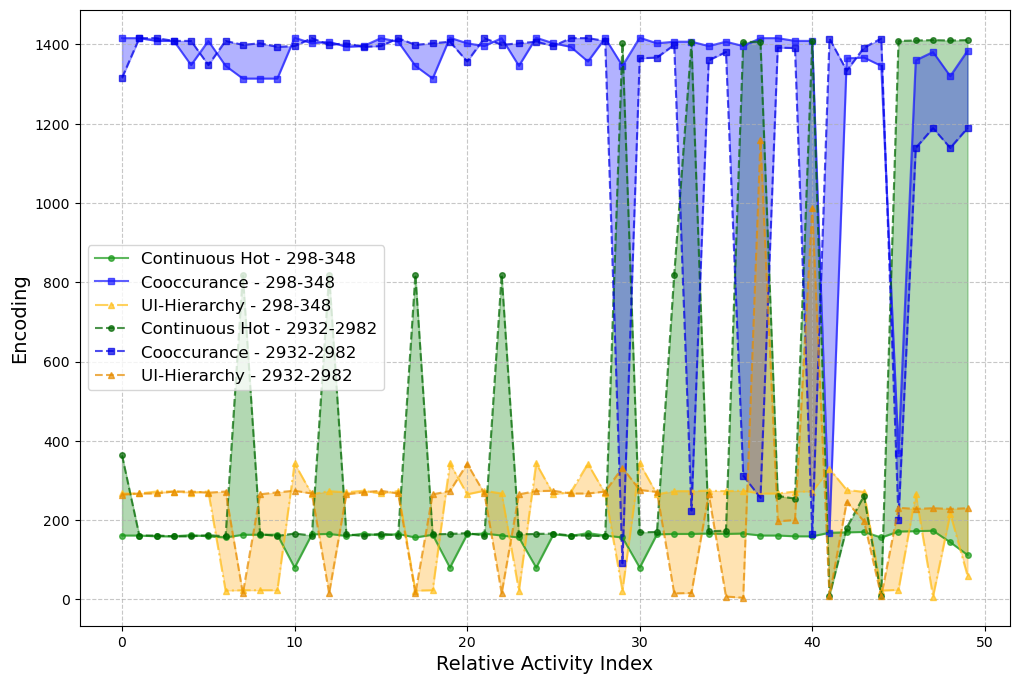

In [64]:
# Function to plot tuple:id values for specific ranges
def plot_ranges(df1, df2, df3, range1, range2):
    plt.figure(figsize=(12, 8))

    # Extract values for the specified ranges without normalization
    df1_range1 = df1['tuple:id'][range1[0]:range1[1]].values
    df2_range1 = df2['tuple:id'][range1[0]:range1[1]].values
    df3_range1 = df3['tuple:id'][range1[0]:range1[1]].values

    df1_range2 = df1['tuple:id'][range2[0]:range2[1]].values
    df2_range2 = df2['tuple:id'][range2[0]:range2[1]].values
    df3_range2 = df3['tuple:id'][range2[0]:range2[1]].values

    # Plot range1
    plt.plot(range(50), df1_range1[:50], label='Continuous Hot - 298-348', linestyle='-', marker='o', markersize=4, c=(0.1, 0.6019607843137255, 0.1), alpha=0.7)
    plt.plot(range(50), df2_range1[:50], label='Cooccurance - 298-348', linestyle='-', marker='s', markersize=4, c=(0.1, 0.1, 1.0), alpha=0.7)
    plt.plot(range(50), df3_range1[:50], label='UI-Hierarchy - 298-348', linestyle='-.', marker='^', markersize=4, c=(1.0, 0.7470588235294118, 0.1), alpha=0.7)

    # Plot range2
    plt.plot(range(50), df1_range2[:50], label='Continuous Hot - 2932-2982', linestyle='--', marker='o', markersize=4, c=(0.0, 0.4019607843137255, 0.0), alpha=0.7)
    plt.plot(range(50), df2_range2[:50], label='Cooccurance - 2932-2982', linestyle='--', marker='s', markersize=4, c=(0.0, 0.0, 0.9), alpha=0.7)
    plt.plot(range(50), df3_range2[:50], label='UI-Hierarchy - 2932-2982', linestyle='--', marker='^', markersize=4, c=(0.9, 0.5470588235294118, 0.0), alpha=0.7)

    # Fill area between Continuous Hot and Cooccurance
    plt.fill_between(range(50), df1_range1[:50], df1_range2[:50], color='green', alpha=0.3)
    plt.fill_between(range(50), df2_range1[:50], df2_range2[:50], color='blue', alpha=0.3)
    plt.fill_between(range(50), df3_range1[:50], df3_range2[:50], color='orange', alpha=0.3)

    # Add labels, legend, and grid
    plt.xlabel('Relative Activity Index', fontsize=14)
    plt.ylabel('Encoding', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()


# Call the plot function with specific ranges
plot_ranges(df1=HotEncodedUiLog, df2=cooccurancyEncodedUiLog, df3=hierarchyEncodedUiLog, range1=(298, 348), range2=(2932, 2982))


In [12]:
tm_matrix, event_series = util.util.discover_motifs(log_df, windowSize, normalize=False)
config.STUMPY_EXCL_ZONE_DENOM = 1  # The exclusion zone is i ± window_size
top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=numberOfMotifs)

In [13]:
top_motifs

(array([[7.52471755e-07, 7.81423485e-07, 3.89858349e-06, 3.89858349e-06,
         2.83069259e+00, 3.41548359e+00, 3.44018836e+00, 3.77581095e+00,
         4.08973856e+00, 4.13718210e+00]]),
 array([[ 2657,  2699,  8969,  8995, 10016,  2630,  6962,  1304,  6645,
          7744]], dtype=int64))